In [1]:
import pandas as pd
from altair import *
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

First let's read in the merged dataframe from the last notebook and also drop some entires of professors who are not currently working

In [2]:
df = pd.read_csv("posRating.csv")
df = df[df["avgPay"] > 1000]
df["year"] = df["year"].fillna(2024)
df.head()

,Unnamed: 0,name_x,avgPay,firstName,lastName,department,numEvals,courses,overallRating,materialClear,studentDifficulties,name_y,year,dept,position,education
0,0,"Abercromby, Kira Jorgensen",123885.33,Kira,Abercromby,AERO,20,"['AERO 452', 'AERO 300', 'AERO 101', 'AERO 353...",3.39,3.34,3.42,"Abercromby, Kira J",2008.0,Aerospace Engineering,Professor,"B.S., University of California, Los Angeles, 1..."
1,1,"Abney, Keith A",99122.78,Keith,Abney,PHIL,138,"['PHIL 201', 'PHIL 331', 'PHIL 335', 'PHIL 332...",2.31,2.61,2.05,NaN,2024.0,NaN,Lecturer/TA,NaN
2,2,"Adams, Nikki L",116394.67,Nikki,Adams,BIO,27,"['BIO 336', 'BIO 160', 'ZOO 336', 'BIO 405', '...",2.82,2.68,2.75,"Adams, Nikki L",2002.0,Biological Sciences,Professor,"B.A., University of California, Santa Barbara,..."
3,3,"Adan, Elizabeth",130039.99,Elizabeth,Adan,ART,37,"['ART 112', 'WGS 210', 'ART 311', 'ART 118', '...",3.56,3.66,3.48,"Adan, Elizabeth",2007.0,"Women's, Gender and Queer Studies, Interdiscip...",Professor and WGQS Department Chair,"B.A., University of California, Davis, 1993; M..."
4,4,"Agbo, Samuel O",85824.17,Samuel,Agbo,EE,80,"['EE 306', 'EE 314', 'EE 112', 'EE 212', 'EE 3...",1.23,1.28,1.01,"Agbo, Samuel O",1991.0,Electrical Engineering,Professor,"B.Sc., University of Nigeria, 1975; M.S.E., Un..."


In [3]:
aChart = Chart(df).mark_circle().encode(x="overallRating", y="avgPay", tooltip=["name_x", "department"])
line = aChart.transform_regression("overallRating", "avgPay", method="linear").mark_line(color="red")
aChart + line

alt.LayerChart(...)

When we compare rating to average pay, we can see that there is actually a slight downwards trend. Professors with higher ratings typically get paid a little bit less than professors with lower ratings.

In [4]:
rel = df["department"].map(lambda x: x in ["CPE", "MATE"])
Chart(df[rel]).mark_circle().encode(x="overallRating", y="avgPay", color="department", tooltip=["name_x", "department"])

alt.Chart(...)

However, we can see that ratings and pay varies greatly between different departments. Here, it's clear CPE professors generally have higher ratings and salary than MATE professors

In [5]:
deptStats = df.groupby("department")[["avgPay", "overallRating"]].mean().sort_values(by=["avgPay"]).reset_index()
deptStats.head()

,department,avgPay,overallRating
0,EDUC,11705.655000,3.250000
1,ISLA,28924.885000,3.500000
2,HLTH,46721.110000,3.333333
3,AGED,49994.036667,3.456667
4,ENGR,51085.050000,3.250000


**Let's break down the data by department, and look at some statistics**

In [6]:
STEM = ["ENGR",
"MATE",
"BRAE",
"IME",
"FSN",
"MATH",
"CSC",
"ME",
"CE",
"PHYS",
"BIO",
"STAT",
"ARCE",
"ASCI",
"CM",
"ITP",
"AERO",
"NR",
"EE",
"CHEM",
"BMED",
"CPE",]

A list of all STEM departments

In [7]:
deptStats["STEM"] = deptStats["department"].map(lambda x: x in STEM)

In [8]:
Chart(deptStats).mark_bar().encode(x=X("department", sort="-y"), y="avgPay", color="STEM")

alt.Chart(...)

Here we can see an interesting distribution of pay accross department. First, professors in the GSA department make a lot more money on average than any other department, while the education department makes a lot less. Second, we can see that STEM departments are clustered much higher in pay compared to non-STEM majors.

In [9]:
Chart(deptStats).mark_bar().encode(x=X("department", sort="-y"), y="overallRating", color="STEM")

alt.Chart(...)

Here, we see an inverese trend where many of the professors in STEM are getting lower ratings overall compared to other majors. The largest exception to this is CPE, which has unusually high ratings by professor.

In [10]:
meanPay = deptStats["avgPay"].mean()
meanRating = deptStats["overallRating"].mean()

def adjustPay(x):
  dept = x["department"]
  affect = deptStats[deptStats["department"] == dept]["avgPay"].iloc[0] - meanPay
  return x["avgPay"] - affect

def adjustRating(x):
  dept = x["department"]
  affect = deptStats[deptStats["department"] == dept]["overallRating"].iloc[0] - meanRating
  return x["overallRating"] - affect

df["adjustedPay"] = df.apply(adjustPay, axis=1)
df["adjustedRating"] = df.apply(adjustRating, axis=1)

Let's use these statistics to adjust for the affect that department has on pay and rating. We now have an adjusted version of each of these variables which is centered around the overall mean

In [11]:
aChart = Chart(df).mark_circle().encode(x="adjustedRating", y="adjustedPay")

aChart

alt.Chart(...)

Once accounting for department, our data points are more centered and consistent.

In [12]:
line = aChart.transform_regression("adjustedRating", "adjustedPay", method="linear").mark_line(color="red")

aChart + line

alt.LayerChart(...)

By plotting a trend line on this graph, we can see that the downwards trend has been eliminated. This is likely because the depatments with high pay and low ratings have been accounted for, equalizing our data.

To me it looked like this data had a slight curve in the middle, so I checked for a quadratic correlation:

In [13]:
aChart = Chart(df).mark_circle().encode(x="adjustedRating", y="adjustedPay", tooltip=["name_x", "department"])
line = aChart.transform_regression("adjustedRating", "adjustedPay", method="quad").mark_line(color="red")
aChart + line

alt.LayerChart(...)

In [14]:
def quadCorr(x,y):
  x = np.array(list(x))
  y = np.array(list(y))
  poly = PolynomialFeatures(degree=2)
  x_poly = poly.fit_transform(x.reshape(-1, 1))

  model = LinearRegression()
  model.fit(x_poly, y)

  y_pred = model.predict(x_poly)

  return r2_score(y, y_pred)

In [15]:
r1 = quadCorr(df["adjustedRating"],df["adjustedPay"])
r2 = quadCorr(df["overallRating"],df["avgPay"])
print(f"The R squared for our origional data is {r2}, and for our adjusted is {r1}")

The R squared for our origional data is 0.0482003335033504, and for our adjusted is 0.038486932403555274


Due to these very small R squared values, we can see that there is not a significant quadratic correlation. This supports the idea that there is not a correlation between polyrating and professor salary.

**So what variables *do* have an affect on professor salary?**

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

We'll start by looking at k-nearest neighbor models for a few different variables, but first we should clean up our data to account for a few departments that only have a few professors

In [17]:
deptNums = df["department"].value_counts()
def clean(d):
  if deptNums.loc[d] > 3:
    return d
  else:
    return "OTHER"

df["deptCleaned"] = df["department"].map(clean)

This code gives us a new category for the departments that only have a few professors, which allows us to more effectively train a pipeline

In [18]:
def getError(scals, cat, TF, K):
  ct = make_column_transformer(
      (StandardScaler(), scals),
      (OneHotEncoder(), cat),
      (TfidfVectorizer(norm=None,max_features=25), TF),
      remainder="drop"
  )
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=K, metric='euclidean')
  )

  pipeline.fit(X=df[scals + cat + TF], y=df["avgPay"])
  scores = cross_val_score(pipeline,
                          X=df[scals + cat + TF],
                          y=df["avgPay"],
                          scoring="neg_mean_squared_error",
                          cv=5)
  return -scores.mean()

In [19]:
class MultiColumnTfidfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.vectorizers = {col: TfidfVectorizer() for col in columns}

    def fit(self, X, y=None):
        for col in self.columns:
            self.vectorizers[col].fit(X[col])
        return self

    def transform(self, X):
        tfidf_features = [self.vectorizers[col].transform(X[col]).toarray() for col in self.columns]
        return np.hstack(tfidf_features)

def getPipeline(scals,cat, TF, K):
  ct = make_column_transformer(
      (StandardScaler(), scals),
      (OneHotEncoder(), cat),
      (MultiColumnTfidfTransformer(TF), TF),
      remainder="drop"
  )
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=K, metric='euclidean')
  )

  pipeline.fit(X=df[scals + cat + TF], y=df["avgPay"])
  return pipeline

def getError(scals, cat, TF, K):
  pipeline = getPipeline(scals,cat,TF,K)
  scores = cross_val_score(pipeline,
                          X=df[scals + cat + TF],
                          y=df["avgPay"],
                          scoring="neg_mean_squared_error",
                          cv=5)
  return -scores.mean()

In [20]:
df.columns

Index(['Unnamed: 0', 'name_x', 'avgPay', 'firstName', 'lastName', 'department',
       'numEvals', 'courses', 'overallRating', 'materialClear',
       'studentDifficulties', 'name_y', 'year', 'dept', 'position',
       'education', 'adjustedPay', 'adjustedRating', 'deptCleaned'],
      dtype='object')

In [21]:
params  = [([],["deptCleaned"], []),
           ([],["deptCleaned"], ["position"]),
          (["numEvals"],["deptCleaned"], ["position"]),
          (["year"],["deptCleaned"], ["position"]),
           (["year", "numEvals"],["deptCleaned"], ["position"]),
           (["year", "numEvals", "overallRating"],["deptCleaned"], ["position"]),
           (["year", "numEvals", "materialClear"],["deptCleaned"], ["position"]),
           (["year", "numEvals", "studentDifficulties"],["deptCleaned"], ["position"])]
df_params = pd.DataFrame({"params" : params})

In [22]:
df_params["error"] = df_params["params"].map(lambda x: getError(*x, 10))

In [23]:
df_params

,params,error
0,"([], [deptCleaned], [])",1.924202e+09
1,"([], [deptCleaned], [position])",1.110137e+09
2,"([numEvals], [deptCleaned], [position])",9.497470e+08
3,"([year], [deptCleaned], [position])",9.156476e+08
4,"([year, numEvals], [deptCleaned], [position])",9.004484e+08
5,"([year, numEvals, overallRating], [deptCleaned...",8.840311e+08
6,"([year, numEvals, materialClear], [deptCleaned...",8.852320e+08
7,"([year, numEvals, studentDifficulties], [deptC...",9.197836e+08


In [24]:
pipeline = getPipeline(["year", "numEvals", "overallRating"],["deptCleaned"], ["position"], 5)

We can see that we get the lowest error when using year, position, department, number of evaulations, and overall rating. It is odd that the model which includes polyrating has a lower error, given that overall rating should not have much of an affect on predicted salary.

**Let's look into why polyratings are affecting our model**

The most obvious reason for this would be an interaction between variables

In [25]:
from sklearn.inspection import PartialDependenceDisplay

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

X = df[["year", "numEvals", "overallRating", "deptCleaned", "position"]]

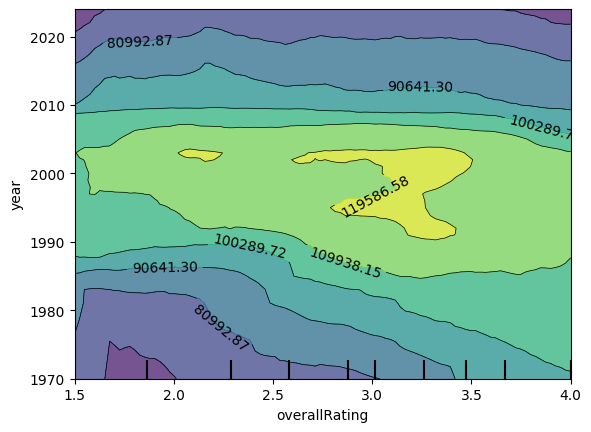

In [29]:
PartialDependenceDisplay.from_estimator(pipeline, X, features=[("overallRating", "year")])

Here we can see that there isn't a correlation between rating and pay for newer profesors, however professors who were hired before 1990 do seem to have higher pay on average when their rating is higher.

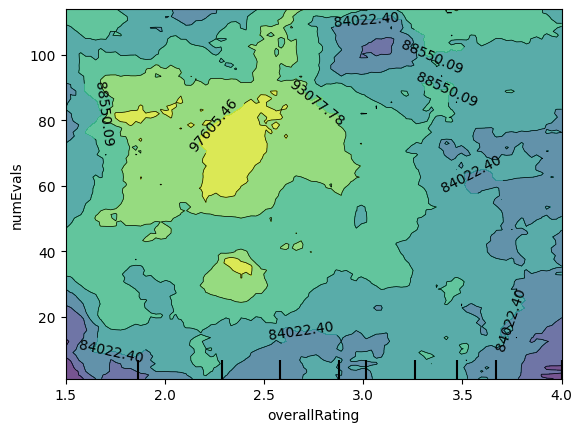

In [34]:
PartialDependenceDisplay.from_estimator(pipeline, X, features=[("overallRating", "numEvals")])

The interaction between rating and number of evaluations is a little bit more complex. For higher ratings, expected pay does not vary much based on number of evaluations. However, the optimal values for rating and number of evaluations seems to be around 2.3 stars and 70 ratings.

**Let's look at how predicted pay changes over time**

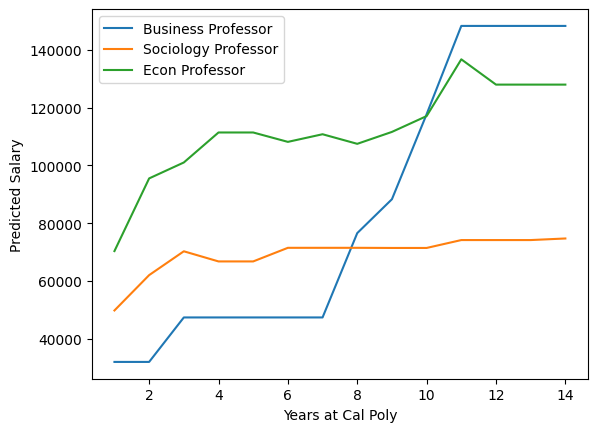

In [39]:
def getYears(dep, evals, rating, x):
    df_temp = pd.DataFrame({"year":x,
                      "deptCleaned":[dep] * len(x),
                      "position":["Profesor"] * len(x),
                      "numEvals":[evals] * len(x),
                      "overallRating" : [rating] * len(x)})
    y = list(reversed(list(pipeline.predict(df_temp))))
    x = list(reversed(list(df_temp["year"].map(lambda x: 2024 - x))))

    return x,y

x,y1 = getYears("BUS", 10, 4, range(2010, 2024))
x,y2 = getYears("SOC", 10, 4, range(2010, 2024))
x,y3 = getYears("ECON", 10, 4, range(2010, 2024))

plt.plot(x, y1, label='Business Professor')
plt.plot(x, y2, label='Sociology Professor')
plt.plot(x, y3, label='Econ Professor')

plt.xlabel('Years at Cal Poly')
plt.ylabel('Predicted Salary')
plt.legend()

plt.show()

Here we can see the predicted salaries of a math professor, econ professor, and sociology professor based on how long they've been at Cal Poly.It's interesting how much more salaries vary for business professors versus sociology professors.